# Clustering India's Urban Cities

### Python Project

In [139]:
## all imports

import types
import pandas as pd
from botocore.client import Config
import ibm_boto3
import requests
import numpy as np
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_samples, silhouette_score
from sklearn.cluster import DBSCAN
from sklearn import metrics
import matplotlib.pyplot as plt
from geopy.geocoders import Nominatim 
import matplotlib.cm as cm
import matplotlib.colors as colors
import matplotlib.pyplot as plt

## 1. Read WorldCities file stored in Project Cloud

In [140]:
def __iter__(self): return 0

{
    "tags": [
        "hidecode",
    ]
}

# @hidden_cell
# The following code accesses a file in your IBM Cloud Object Storage. It includes your credentials.
# You might want to remove those credentials before you share your notebook.
client_e8764c861c054a20afb6b04c6ac44ea0 = ibm_boto3.client(service_name='s3',
    ibm_api_key_id='jW2kFAJXBCCzrfe6UgP3T4Lt-KyG0vY-sJqXsSHMGE8Y',
    ibm_auth_endpoint="https://iam.bluemix.net/oidc/token",
    config=Config(signature_version='oauth'),
    endpoint_url='https://s3-api.us-geo.objectstorage.service.networklayer.com')

body = client_e8764c861c054a20afb6b04c6ac44ea0.get_object(Bucket='courseracapstone-donotdelete-pr-keavguhvhxmj3o',Key='worldcities.csv')['Body']
# add missing __iter__ method, so pandas accepts body as file-like object
if not hasattr(body, "__iter__"): body.__iter__ = types.MethodType( __iter__, body )

df_worldcities = pd.read_csv(body)
df_worldcities.head()

,city,city_ascii,lat,lng,country,iso2,iso3,admin_name,capital,population,id
0,Malishevë,Malisheve,42.4822,20.7458,Kosovo,XK,XKS,Malishevë,admin,NaN,1901597212
1,Prizren,Prizren,42.2139,20.7397,Kosovo,XK,XKS,Prizren,admin,NaN,1901360309
2,Zubin Potok,Zubin Potok,42.9144,20.6897,Kosovo,XK,XKS,Zubin Potok,admin,NaN,1901608808
3,Kamenicë,Kamenice,42.5781,21.5803,Kosovo,XK,XKS,Kamenicë,admin,NaN,1901851592
4,Viti,Viti,42.3214,21.3583,Kosovo,XK,XKS,Viti,admin,NaN,1901328795


In [141]:
# Examining the column data types
df_worldcities.dtypes

city           object
city_ascii     object
lat           float64
lng           float64
country        object
iso2           object
iso3           object
admin_name     object
capital        object
population    float64
id              int64
dtype: object

## 2. Cleanse Data

### 2.1 Extract Indian cities

There are 212 Indian cities in the World Cities dataset

In [142]:
df_indiancities = df_worldcities[df_worldcities.country == 'India']
print(df_indiancities.shape)
df_indiancities.head()

(212, 11)


,city,city_ascii,lat,lng,country,iso2,iso3,admin_name,capital,population,id
7399,Kavaratti,Kavaratti,10.5626,72.6369,India,IN,IND,Lakshadweep,admin,10688.0,1356089869
7400,New Delhi,New Delhi,28.6000,77.2000,India,IN,IND,Delhi,primary,317797.0,1356215164
7401,Tezpur,Tezpur,26.6338,92.8000,India,IN,IND,Assam,NaN,58851.0,1356299437
7402,Jullundur,Jullundur,31.3349,75.5690,India,IN,IND,Punjab,NaN,855000.0,1356494816
7403,Navsari,Navsari,20.8504,72.9200,India,IN,IND,Gujarāt,NaN,163000.0,1356120513


### 2.2. Remove redundant columns

In [143]:
# Keep only required columns

df_indiancities = df_indiancities[['city', 'lat', 'lng', 'country', 'capital', 'population']]
df_indiancities = df_indiancities.sort_values('city')
df_indiancities.head()

,city,lat,lng,country,capital,population
7505,Abohar,30.1204,74.290,India,NaN,130603.0
7425,Agartala,23.8354,91.280,India,admin,203264.0
7506,Agra,27.1704,78.015,India,NaN,1592000.0
7420,Ahmedabad,23.0301,72.580,India,minor,5375000.0
7490,Ahmednagar,19.1104,74.750,India,NaN,391760.0


## 3. Get Foursquare data for cities

### 3.1 Define Foursquare credentials and version

In [144]:
{
    "tags": [
        "hidecode",
    ]
}

# Define Foursquare credentials and version

CLIENT_ID = 'IFGZGX4XZGUBSO53CJTLZUUVMW5NKPZBEVBAOYC33HNNOOPI' # your Foursquare ID
CLIENT_SECRET = 'I2HICT0K4TVXU1QTVBNMYZTCPEFPVPXF0RCGBSRBA0OQF2KP' # your Foursquare Secret
VERSION = '20180605' # Foursquare API version

### 3.2 Get top venues for each city

#### 3.2.1 Define function
This function retrieves the top venues for a city based on Foursquare check-in data. <br>
**Data cleansing**: 
- The function eliminates cities that have no Foursquare check-ins
- The function also eliminates cities that do not have at least 10 venues on Foursquare

In [174]:
# Function to get top venues for each neighbourhood

def getCityVenues(names, populations, latitudes, longitudes, radius=50000, LIMIT=100):
    
    intent = 'browse'
    venues_list=[]
    for name, population, lat, lng in zip(names, populations, latitudes, longitudes):
        venueCount = 0
            
        # create the API request URL
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            LIMIT)
            
        # make the GET request
        result = requests.get(url)
        
        # proceed only if the response is not empty 
        if (result is not None) and (result != ''):
            venueCount = result.json()["response"]['totalResults']
            print(name, venueCount)
            if venueCount > 4:
                results = result.json()["response"]['groups'][0]['items']
            
            # return only relevant information for each nearby venue
                venues_list.append([(
                        name,
                        population,
                        lat,
                        lng,
                        v['venue']['name'],
                        v['venue']['location']['lat'],
                        v['venue']['location']['lng'],
                        v['venue']['categories'][0]['name']) for v in results])

    city_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    city_venues.columns = ['City', 
                           'City Population',
                           'City Latitude',
                           'City Longitude', 
                           'Venue',
                           'Venue Latitude',
                           'Venue Longitude',
                           'Venue Category']
    
    return(city_venues)

#### 3.2.2 City venues in a new dataframe

In [146]:
city_venues = getCityVenues(names=df_indiancities['city'],
                            populations=df_indiancities['population'],
                            latitudes=df_indiancities['lat'],
                            longitudes=df_indiancities['lng']
                            )

print(city_venues.shape)
print('There are {} cities eligible for analysis.'.format(len(city_venues['City'].unique())))

Abohar 5
Agartala 6
Agra 58
Ahmedabad 96
Ahmednagar 10
Aizawl 5
Ajmer 28
Akola 11
Alappuzha 81
Aligarh 10
Alipur Duar 6
Allahabad 16
Alwar 10
Ambala 66
Amravati 6
Amritsar 50
Asansol 7
Aurangabad 22
Aurangabad 8
Bahraich 7
Bangalore 207
Baramula 33
Barddhaman 4
Bareilly 4
Belgaum 29
Bellary 4
Bhagalpur 8
Bharatpur 22
Bhatpara 129
Bhavnagar 19
Bhilai 32
Bhilwara 4
Bhiwandi 234
Bhiwani 6
Bhopal 36
Bhubaneshwar 60
Bhuj 11
Bhusawal 9
Bidar 10
Bijapur 9
Bikaner 7
Bilaspur 4
Brahmapur 8
Budaun 4
Bulandshahr 6
Burhanpur 5
Chandigarh 54
Chandrapur 10
Chennai 189
Chirala 5
Coimbatore 87
Cuddalore 69
Cuttack 61
Daman 45
Davangere 15
Dehra Dun 96
Delhi 240
Dhanbad 9
Dhule 12
Dibrugarh 9
Dindigul 13
Dispur 44
Diu 9
Etawah 6
Faizabad 7
Faridabad 240
Fatehpur 8
Firozabad 45
Gandhinagar 96
Gangtok 27
Gaya 7
Ghaziabad 240
Gorakhpur 6
Gulbarga 5
Guntur 68
Gurgaon 239
Guwahati 43
Gwalior 10
Haldia 5
Haora 119
Hapur 49
Hathras 57
Hindupur 3
Hisar 4
Hoshiarpur 31
Hospet 29
Hubli 22
Hyderabad 173
Imphal 4


### 3.3 Visualizing Cities

In [147]:
# Get geographical coordinates of India

address = 'India'

# convert an address into latitude and longitude values
geolocator = Nominatim(user_agent="ny_explorer")
location = geolocator.geocode(address)
latitude = location.latitude
longitude = location.longitude
print('The geograpical coordinates of India are {}, {}.'.format(latitude, longitude))

The geograpical coordinates of India are 22.3511148, 78.6677428.


In [148]:
#Install folium
! pip install folium

tensorflow 1.3.0 requires tensorflow-tensorboard<0.2.0,>=0.1.0, which is not installed.


In [149]:
import folium
# create map
map_clusters = folium.Map(location=[latitude, longitude], zoom_start=4)

# add markers to the map
for lat, lon, city in zip(df_indiancities['lat'], df_indiancities['lng'], df_indiancities['city']):
    label = folium.Popup(str(city), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        #color=rainbow[int(cluster-1)],
        fill=True,
        #fill_color=rainbow[int(cluster-1)],
        fill_opacity=0.7).add_to(map_clusters)
       
map_clusters

## 4. Analyze cities based on categories from all the returned venues

### 4.1 Find number of unique venue categories - overall and across cities

In [150]:
print('There are {} unique venue categories overall.'.format(len(city_venues['Venue Category'].unique())))

# Find the distrobution of venue categories across cities
venue_category_freq = city_venues.groupby(['Venue Category'])['City'].nunique()
venue_category_freq = venue_category_freq.reset_index(name='Count').sort_values(by='Count',ascending=False)
print('The top 10 venue categories common across cities are:')
venue_category_freq.head(25)


There are 271 unique venue categories overall.
The top 10 venue categories common across cities are:


,Venue Category,Count
130,Indian Restaurant,154
123,Hotel,136
43,Café,135
258,Train Station,114
193,Pizza Place,109
221,Shopping Mall,97
58,Coffee Shop,94
170,Multiplex,94
85,Fast Food Restaurant,90
207,Restaurant,82


### 4.2 Eliminate top 3 venue categories common across most cities 

In [151]:
# Extract the top most common venue categories
venue_category_top = venue_category_freq['Venue Category'].head(3)

city_venues = city_venues[~city_venues['Venue Category'].isin(venue_category_top)]

# Find the number of unique categories per city
city_venues_categories = city_venues.groupby('City')['Venue Category'].nunique()
city_venues_categories = city_venues_categories.reset_index(name='Category Count').sort_values(by='Category Count',ascending=False)
print(city_venues_categories.shape)
city_venues_categories.head()

(210, 2)


,City,Category Count
19,Bangalore,47
131,Mumbai,45
47,Chennai,43
107,Kochi,42
99,Kalyan,42


Avg number of unique venues per city:  14.480952380952381
Max number of unique venues per city:  47
Min number of unique venues per city:  1
Median number of unique venues per city:  10.0
30% point:  5.0


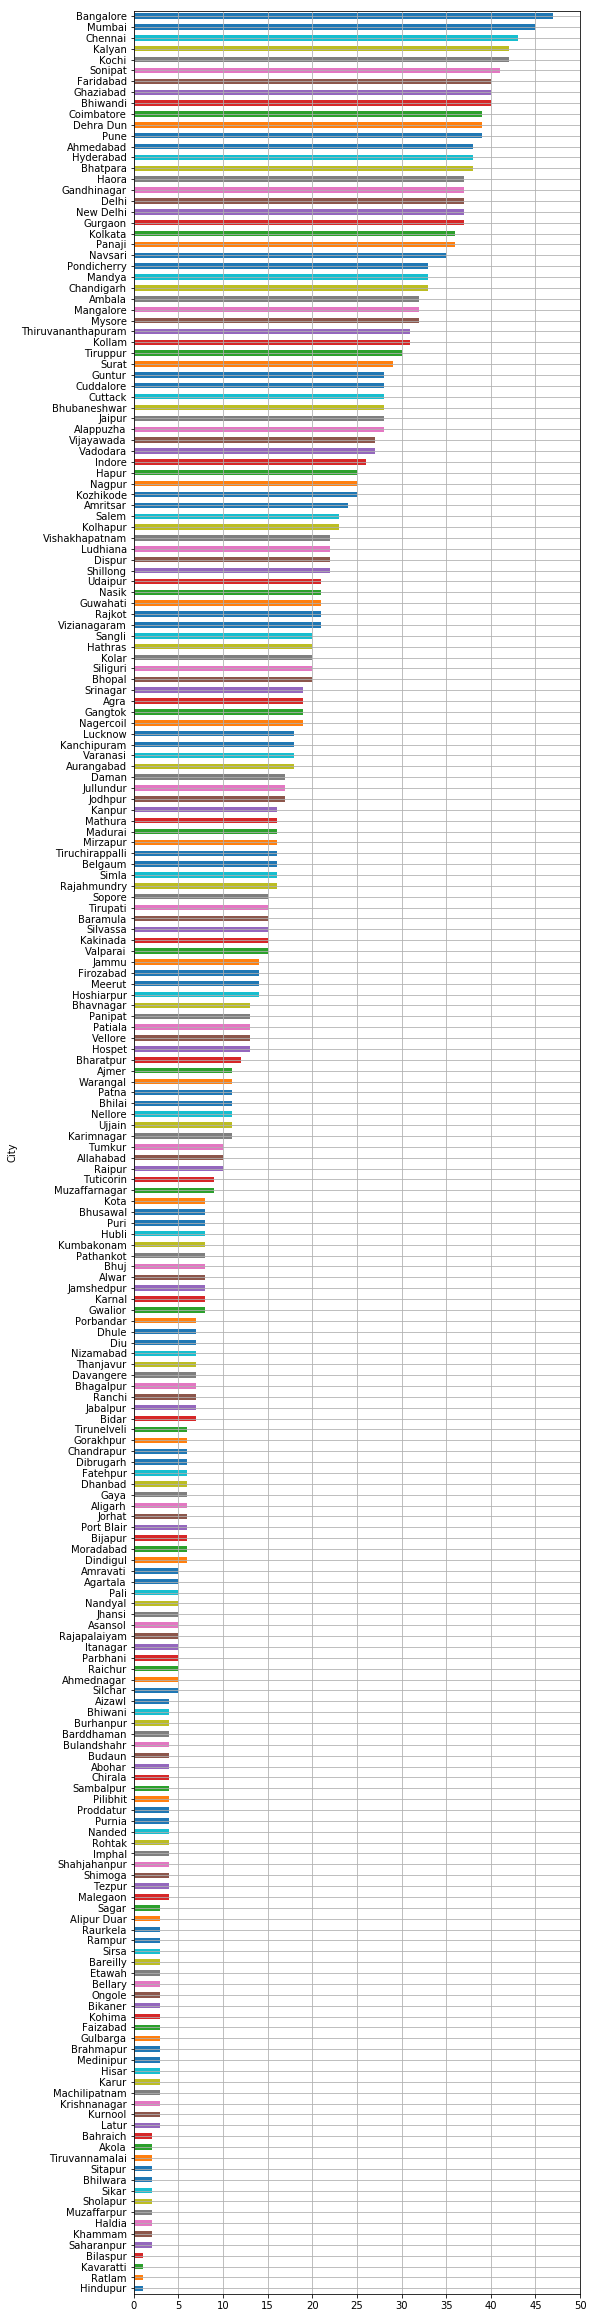

In [153]:
# Descriptive staistics for venue categories

final_city_ucatg_count = city_venues.groupby('City')['Venue Category'].nunique().sort_values(ascending=True)

print('Avg number of unique venues per city: ',final_city_ucatg_count.mean())
print('Max number of unique venues per city: ',final_city_ucatg_count.max())
print('Min number of unique venues per city: ',final_city_ucatg_count.min())
print('Median number of unique venues per city: ',final_city_ucatg_count.median())
print('30% point: ',final_city_ucatg_count.quantile(q=0.30))

final_city_ucatg_count.plot(kind='barh',figsize=[8,42],grid=True,xticks=range(0,51,5))

In [154]:
# Find the number of cities remaining
print('There are {} cities remaining.'.format(len(city_venues['City'].unique())))
print('There are {} unique venue categories remaining.'.format(len(city_venues['Venue Category'].unique())))

There are 210 cities remaining.
There are 268 unique venue categories remaining.


### 4.3 Create list of venue categories for each city

In [155]:
# one hot encoding
city_onehot = pd.get_dummies(city_venues[['Venue Category']], prefix="", prefix_sep="")

# add city and population columns back to dataframe
city_onehot.insert(loc=0, column='City Name', value=city_venues['City'])
city_onehot.insert(loc=1, column='Population', value=city_venues['City Population'])

print(city_onehot.shape)
city_onehot.head()

(4796, 270)


,City Name,Population,ATM,Accessories Store,Afghan Restaurant,Airport,Airport Lounge,Airport Service,Airport Terminal,American Restaurant,...,University,Vegetarian / Vegan Restaurant,Video Store,Vineyard,Watch Shop,Water Park,Waterfall,Yoga Studio,Zoo,Zoo Exhibit
0,Abohar,130603.0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,Abohar,130603.0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,Abohar,130603.0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,Abohar,130603.0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
5,Agartala,203264.0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [156]:
# group rows by city and by taking the mean of the frequency of occurrence of each category
city_grouped = city_onehot.groupby(['City Name', 'Population']).mean().reset_index()

print(city_grouped.shape)
city_grouped.head()

(211, 270)


,City Name,Population,ATM,Accessories Store,Afghan Restaurant,Airport,Airport Lounge,Airport Service,Airport Terminal,American Restaurant,...,University,Vegetarian / Vegan Restaurant,Video Store,Vineyard,Watch Shop,Water Park,Waterfall,Yoga Studio,Zoo,Zoo Exhibit
0,Abohar,130603.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,...,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,Agartala,203264.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,...,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,Agra,1592000.0,0.0,0.0,0.0,0.030303,0.0,0.0,0.0,0.0,...,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,Ahmedabad,5375000.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,...,0.0,0.044118,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,Ahmednagar,391760.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,...,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


### 4.4 Top 5 most common venues in the cities

In [157]:
# Function to sort venues in descending order
def return_most_common_venues(row, num_top_venues):
    row_categories = row.iloc[2:]
    row_categories_sorted = row_categories.sort_values(ascending=False)

    row_top_categories = np.array([])
    
    for num in range(0,num_top_venues):
        if row_categories_sorted[num] != 0:
            row_top_categories = np.append(row_top_categories,row_categories_sorted.index.values[num])
        else:
            row_top_categories = np.append(row_top_categories,'')
            
    return row_top_categories
#    return row_categories_sorted.index.values[0:num_top_venues]



In [158]:
# Create dataframe with top 5 venues for each city
num_top_venues = 5

indicators = ['st', 'nd', 'rd']

# create columns according to number of top venues
columns = ['City', 'Population']
for ind in np.arange(num_top_venues):
    try:
        columns.append('{}{} Most Common Venue'.format(ind+1, indicators[ind]))
    except:
        columns.append('{}th Most Common Venue'.format(ind+1))

# create a new dataframe
city_venues_sorted = pd.DataFrame(columns=columns)
city_venues_sorted['City'] = city_grouped['City Name']
city_venues_sorted['Population'] = city_grouped['Population']

for ind in np.arange(city_grouped.shape[0]):
    city_venues_sorted.iloc[ind, 2:] = return_most_common_venues(city_grouped.iloc[ind, :], num_top_venues)

city_venues_sorted.head()

,City,Population,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue
0,Abohar,130603.0,Spa,Platform,Pizza Place,Shop & Service,
1,Agartala,203264.0,Train Station,Food Court,Men's Store,Platform,Clothing Store
2,Agra,1592000.0,Historic Site,Coffee Shop,Multicuisine Indian Restaurant,Pizza Place,Resort
3,Ahmedabad,5375000.0,Restaurant,Multiplex,Fast Food Restaurant,Coffee Shop,Ice Cream Shop
4,Ahmednagar,391760.0,Coffee Shop,Multiplex,Snack Place,Pizza Place,Italian Restaurant


## 5. Clustering cities using K-Means algorithm

### 5.1 K-Means is run for clusters 5, 6, 7, 8, 9, 10 and optimal number determined through Elbow method

In [159]:
# set number of clusters
range_n_clusters = range(5,10)
Sum_of_squared_distances = []

city_grouped_clustering = city_grouped.drop(['City Name','Population'], 1)

# run k-means clustering iteratively to determine optimum cluster number
for kclusters in range_n_clusters:
    kmeans = KMeans(n_clusters=kclusters, init='k-means++', random_state=0).fit(city_grouped_clustering)
    Sum_of_squared_distances.append(kmeans.inertia_)

### 5.2 Plot of Sum of Squared Distances for all cluster numbers (Elbow method)

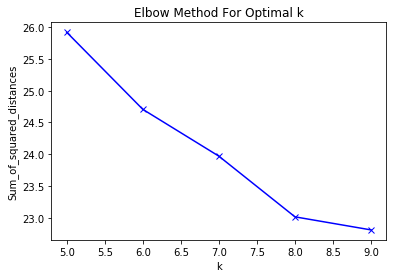

In [160]:
# Plot of sum of squared distances for values of ok
# If the plot looks like an arm, then the elbow on the arm is optimal k

plt.plot(range_n_clusters, Sum_of_squared_distances, 'bx-')
plt.xlabel('k')
plt.ylabel('Sum_of_squared_distances')
plt.title('Elbow Method For Optimal k')
plt.show()

### 5.3 Average Silhouette Method

For n_clusters = 5 The average silhouette_score is : 0.0830042661713
For n_clusters = 6 The average silhouette_score is : 0.133218891171
For n_clusters = 7 The average silhouette_score is : 0.0979259851526
For n_clusters = 8 The average silhouette_score is : 0.0712642842476
For n_clusters = 9 The average silhouette_score is : 0.0841942216919


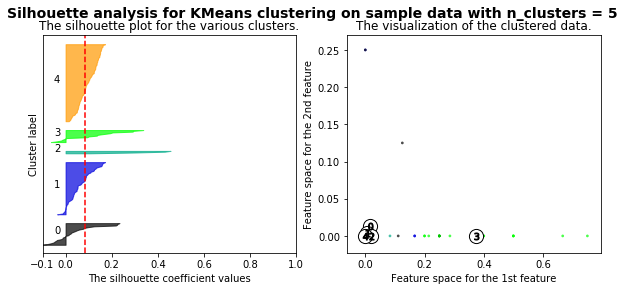

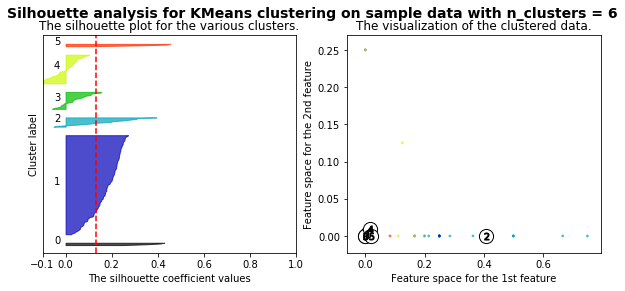

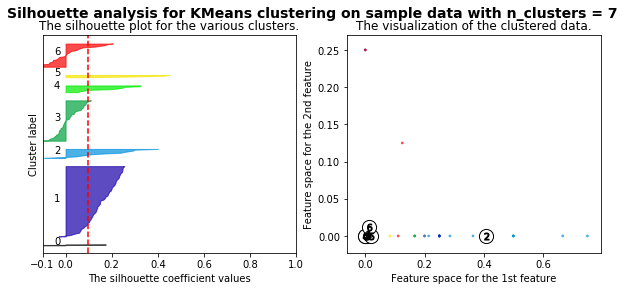

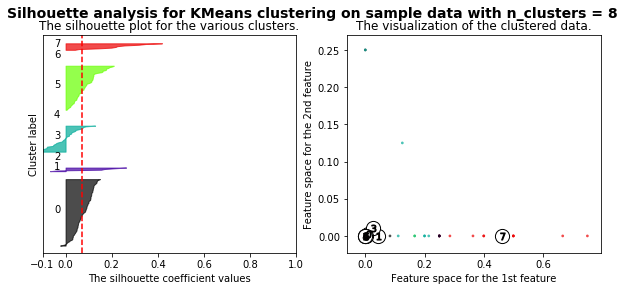

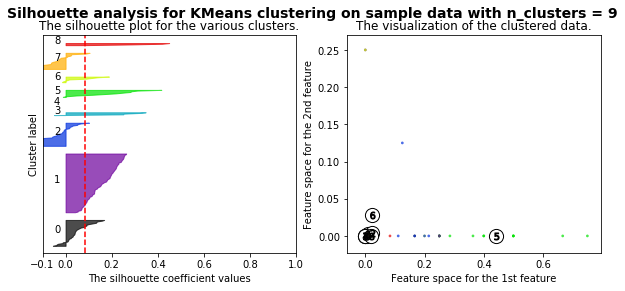

In [177]:
X = city_grouped_clustering

range_n_clusters = range(5,10)

for n_clusters in range_n_clusters:
    # Create a subplot with 1 row and 2 columns
    fig, (ax1, ax2) = plt.subplots(1, 2)
    fig.set_size_inches(10, 4)

    # The 1st subplot is the silhouette plot
    # The silhouette coefficient can range from -1, 1 but in this example all
    # lie within [-0.1, 1]
    ax1.set_xlim([-0.1, 1])
    # The (n_clusters+1)*10 is for inserting blank space between silhouette
    # plots of individual clusters, to demarcate them clearly.
    ax1.set_ylim([0, len(X) + (n_clusters + 1) * 10])

    # Initialize the clusterer with n_clusters value and a random generator
    # seed of 10 for reproducibility.
    clusterer = KMeans(n_clusters=n_clusters, random_state=10)
    cluster_labels = clusterer.fit_predict(X)

    # The silhouette_score gives the average value for all the samples.
    # This gives a perspective into the density and separation of the formed
    # clusters
    silhouette_avg = silhouette_score(X, cluster_labels)
    print("For n_clusters =", n_clusters,
          "The average silhouette_score is :", silhouette_avg)

    # Compute the silhouette scores for each sample
    sample_silhouette_values = silhouette_samples(X, cluster_labels)

    y_lower = 10
    for i in range(n_clusters):
        # Aggregate the silhouette scores for samples belonging to
        # cluster i, and sort them
        ith_cluster_silhouette_values = \
            sample_silhouette_values[cluster_labels == i]

        ith_cluster_silhouette_values.sort()

        size_cluster_i = ith_cluster_silhouette_values.shape[0]
        y_upper = y_lower + size_cluster_i

        colour = cm.nipy_spectral(float(i) / n_clusters)
        ax1.fill_betweenx(np.arange(y_lower, y_upper),
                          0, ith_cluster_silhouette_values,
                          facecolor=colour, edgecolor=colour, alpha=0.7)

        # Label the silhouette plots with their cluster numbers at the middle
        ax1.text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))

        # Compute the new y_lower for next plot
        y_lower = y_upper + 10  # 10 for the 0 samples

    ax1.set_title("The silhouette plot for the various clusters.")
    ax1.set_xlabel("The silhouette coefficient values")
    ax1.set_ylabel("Cluster label")

    # The vertical line for average silhouette score of all the values
    ax1.axvline(x=silhouette_avg, color="red", linestyle="--")

    ax1.set_yticks([])  # Clear the yaxis labels / ticks
    ax1.set_xticks([-0.1, 0, 0.2, 0.4, 0.6, 0.8, 1])

    # 2nd Plot showing the actual clusters formed
    colours = cm.nipy_spectral(cluster_labels.astype(float) / n_clusters)
    ax2.scatter(X.values[:, 0], X.values[:, 1], marker='.', s=30, lw=0, alpha=0.7,
                c=colours, edgecolor='k')

    # Labeling the clusters
    centers = clusterer.cluster_centers_
    # Draw white circles at cluster centers
    ax2.scatter(centers[:, 0], centers[:, 1], marker='o',
                c="white", alpha=1, s=200, edgecolor='k')

    for i, c in enumerate(centers):
        ax2.scatter(c[0], c[1], marker='$%d$' % i, alpha=1,
                    s=50, edgecolor='k')

    ax2.set_title("The visualization of the clustered data.")
    ax2.set_xlabel("Feature space for the 1st feature")
    ax2.set_ylabel("Feature space for the 2nd feature")

    plt.suptitle(("Silhouette analysis for KMeans clustering on sample data "
                  "with n_clusters = %d" % n_clusters),
                 fontsize=14, fontweight='bold')

plt.show()

#### Optimum number of cluster = 8 based on Elbow method

### 5.3 Running K-Means for 8 clusters

In [161]:
kmeans = KMeans(n_clusters=8, random_state=0).fit(city_grouped_clustering)

# check cluster labels generated for each row in the dataframe
kmeans.labels_[0:10]

array([3, 2, 0, 1, 3, 1, 3, 4, 1, 7], dtype=int32)

### 5.4 Assign cluster label to each neighbourhood

In [162]:
# add clustering labels
#del city_venues_sorted['Cluster Labels']
city_venues_sorted.insert(0, 'Cluster Labels', kmeans.labels_)

city_merged = df_indiancities

# merge city_venues with city_venues_sorted to add latitude/longitude for each City
city_merged = city_merged.join(city_venues_sorted.set_index('City'), on='city')
city_merged = city_merged.dropna(subset=['Population'])

city_merged.head()

,city,lat,lng,country,capital,population,Cluster Labels,Population,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue
7505,Abohar,30.1204,74.290,India,NaN,130603.0,3.0,130603.0,Spa,Platform,Pizza Place,Shop & Service,
7425,Agartala,23.8354,91.280,India,admin,203264.0,2.0,203264.0,Train Station,Food Court,Men's Store,Platform,Clothing Store
7506,Agra,27.1704,78.015,India,NaN,1592000.0,0.0,1592000.0,Historic Site,Coffee Shop,Multicuisine Indian Restaurant,Pizza Place,Resort
7420,Ahmedabad,23.0301,72.580,India,minor,5375000.0,1.0,5375000.0,Restaurant,Multiplex,Fast Food Restaurant,Coffee Shop,Ice Cream Shop
7490,Ahmednagar,19.1104,74.750,India,NaN,391760.0,3.0,391760.0,Coffee Shop,Multiplex,Snack Place,Pizza Place,Italian Restaurant


### 5.5 Visualize city clusters on map

In [163]:
import folium
# create map
map_clusters = folium.Map(location=[latitude, longitude], zoom_start=4)

# set color scheme for the clusters
x = np.arange(kclusters)
ys = [i + x + (i*x)**2 for i in range(kclusters)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]
city_merged = city_merged.dropna(subset=['Cluster Labels'])

# add markers to the map
markers_colors = []
for lat, lon, poi, cluster in zip(city_merged['lat'], city_merged['lng'], city_merged['city'], city_merged['Cluster Labels']):
    label = folium.Popup(str(poi) + ' Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color=rainbow[int(cluster-1)],
        fill=True,
        fill_color=rainbow[int(cluster-1)],
        fill_opacity=0.7).add_to(map_clusters)
       
map_clusters

## 6 Analyzing Clusters

### 6.1 Cluster Sizes

In [164]:
city_merged.groupby(['Cluster Labels'])['city'].nunique()

Cluster Labels
0.0    10
1.0    77
2.0    11
3.0    62
4.0     4
5.0     1
6.0     9
7.0    37
Name: city, dtype: int64

### Cluster #1 - Historic sites

In [165]:
city_merged.loc[city_merged['Cluster Labels'] == 0, city_merged.columns[[0] + list(range(6, city_merged.shape[1]))]]

,city,Cluster Labels,Population,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue
7506,Agra,0.0,1592000.0,Historic Site,Coffee Shop,Multicuisine Indian Restaurant,Pizza Place,Resort
7428,Bharatpur,0.0,229384.0,Historic Site,City,Mountain,Lake,Comfort Food Restaurant
7540,Bikaner,0.0,576015.0,Historic Site,City,Train Station,,
7436,Hospet,0.0,286007.0,Historic Site,Mountain,Restaurant,Resort,Vegetarian / Vegan Restaurant
7542,Jhansi,0.0,826494.0,Historic Site,City,Bookstore,Video Store,Train Station
7601,Kumbakonam,0.0,139264.0,Historic Site,Train Station,Pool,Beach,Museum
7521,Mathura,0.0,330511.0,Historic Site,City,Train Station,Indian Sweet Shop,Rest Area
7487,Porbandar,0.0,234684.0,Historic Site,Garden,Dhaba,Beach,Airport Terminal
7401,Tezpur,0.0,58851.0,Historic Site,Clothing Store,Vineyard,Mobile Phone Shop,
7602,Thanjavur,0.0,219571.0,Historic Site,Bus Station,Train Station,Pool,Museum


### Cluster #2 - Urban I

In [166]:
city_merged.loc[city_merged['Cluster Labels'] == 1, city_merged.columns[[0] + list(range(6, city_merged.shape[1]))]]

,city,Cluster Labels,Population,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue
7420,Ahmedabad,1.0,5375000.0,Restaurant,Multiplex,Fast Food Restaurant,Coffee Shop,Ice Cream Shop
7451,Aizawl,1.0,283021.0,ATM,Intersection,Shopping Mall,Airport,
7598,Alappuzha,1.0,176783.0,Resort,Bakery,Vegetarian / Vegan Restaurant,Clothing Store,Fried Chicken Joint
7432,Alipur Duar,1.0,127342.0,Embassy / Consulate,Mountain,Asian Restaurant,,
7528,Ambala,1.0,146787.0,Pizza Place,Bakery,Fast Food Restaurant,Multiplex,Restaurant
7446,Bangalore,1.0,6787000.0,Ice Cream Shop,Lounge,Brewery,Pub,Burger Joint
7415,Baramula,1.0,167986.0,Restaurant,Fried Chicken Joint,Garden,Shopping Mall,City
7568,Bareilly,1.0,817000.0,Shopping Mall,Accessories Store,Clothing Store,,
7585,Belgaum,1.0,608756.0,Train Station,Bakery,Restaurant,Asian Restaurant,Coffee Shop
7466,Bhatpara,1.0,483129.0,Chinese Restaurant,Shopping Mall,Dhaba,Bookstore,Mughlai Restaurant


### Cluster #3 - Railway Junction

In [167]:
city_merged.loc[city_merged['Cluster Labels'] == 2, city_merged.columns[[0] + list(range(6, city_merged.shape[1]))]]

,city,Cluster Labels,Population,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue
7425,Agartala,2.0,203264.0,Train Station,Food Court,Men's Store,Platform,Clothing Store
7582,Bellary,2.0,445388.0,Movie Theater,Platform,Train Station,,
7527,Burhanpur,2.0,197233.0,Train Station,Food Truck,Platform,Bus Station,
7571,Chirala,2.0,253000.0,Train Station,Beach,Asian Restaurant,Ice Cream Shop,
7520,Gulbarga,2.0,483615.0,Train Station,Shopping Mall,Mobile Phone Shop,,
7498,Khammam,2.0,290839.0,Train Station,Restaurant,,,
7470,Krishnanagar,2.0,145926.0,Train Station,ATM,Hindu Temple,,
7562,Ongole,2.0,202860.0,Food Court,Train Station,French Restaurant,,
7413,Ratlam,2.0,307229.0,Train Station,,,,
7464,Raurkela,2.0,625831.0,Train Station,Restaurant,Ice Cream Shop,,


### Cluster #4 - Mid size towns I

In [168]:
city_merged.loc[city_merged['Cluster Labels'] == 3, city_merged.columns[[0] + list(range(6, city_merged.shape[1]))]]

,city,Cluster Labels,Population,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue
7505,Abohar,3.0,130603.0,Spa,Platform,Pizza Place,Shop & Service,
7490,Ahmednagar,3.0,391760.0,Coffee Shop,Multiplex,Snack Place,Pizza Place,Italian Restaurant
7572,Ajmer,3.0,589985.0,Pizza Place,Vegetarian / Vegan Restaurant,Lake,City,Bakery
7552,Allahabad,3.0,1201000.0,Fast Food Restaurant,Pizza Place,Flea Market,Multiplex,Shopping Mall
7584,Amritsar,3.0,1212000.0,Pizza Place,Fast Food Restaurant,Multiplex,Diner,Resort
7404,Asansol,3.0,1328000.0,Multiplex,Shopping Mall,Chinese Restaurant,Pizza Place,Train Station
7491,Aurangabad,3.0,1113000.0,Multiplex,Pizza Place,Fast Food Restaurant,Restaurant,Cave
7569,Aurangabad,3.0,1113000.0,Multiplex,Pizza Place,Fast Food Restaurant,Restaurant,Cave
7545,Bahraich,3.0,182218.0,Fast Food Restaurant,Historic Site,,,
7474,Barddhaman,3.0,301725.0,Breakfast Spot,Shopping Mall,Snack Place,Multiplex,


### Cluster #5 - Outlier I

In [169]:
city_merged.loc[city_merged['Cluster Labels'] == 4, city_merged.columns[[0] + list(range(6, city_merged.shape[1]))]]

,city,Cluster Labels,Population,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue
7489,Akola,4.0,503502.0,Mobile Phone Shop,Train Station,,,
7559,Dhule,4.0,479073.0,Mobile Phone Shop,Fast Food Restaurant,Train Station,Dhaba,Diner
7457,Kohima,4.0,92113.0,Airport,Motel,Mobile Phone Shop,,
7488,Parbhani,4.0,378326.0,Mobile Phone Shop,Platform,ATM,Train Station,Bus Stop


### Cluster #6 - Outlier II

In [170]:
city_merged.loc[city_merged['Cluster Labels'] == 5, city_merged.columns[[0] + list(range(6, city_merged.shape[1]))]]

,city,Cluster Labels,Population,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue
7574,Hindupur,5.0,168312.0,Temple,,,,


### Cluster #7 - Mid size Towns II

In [171]:
city_merged.loc[city_merged['Cluster Labels'] == 6, city_merged.columns[[0] + list(range(6, city_merged.shape[1]))]]

,city,Cluster Labels,Population,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue
7491,Aurangabad,6.0,95929.0,ATM,Dhaba,Park,Platform,Train Station
7569,Aurangabad,6.0,95929.0,ATM,Dhaba,Park,Platform,Train Station
7481,Brahmapur,6.0,324726.0,ATM,Train Station,Pizza Place,,
7586,Etawah,6.0,257448.0,ATM,Coffee Shop,Motorcycle Shop,,
7550,Faizabad,6.0,153047.0,ATM,Train Station,Plaza,,
7411,Muzaffarpur,6.0,333200.0,ATM,Train Station,,,
7588,Purnia,6.0,198453.0,Train Station,ATM,Shopping Mall,Motorcycle Shop,
7473,Sikar,6.0,400000.0,ATM,Resort,,,
7426,Silchar,6.0,152393.0,ATM,Airport Terminal,Shopping Mall,Airport,Train Station
7557,Sitapur,6.0,164435.0,ATM,Motorcycle Shop,,,


### Cluster #8

In [172]:
city_merged.loc[city_merged['Cluster Labels'] == 7, city_merged.columns[[0] + list(range(6, city_merged.shape[1]))]]

,city,Cluster Labels,Population,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue
7538,Aligarh,7.0,805000.0,Train Station,Coffee Shop,Rest Area,Comfort Food Restaurant,Fast Food Restaurant
7507,Alwar,7.0,283228.0,Train Station,Scenic Lookout,Platform,Shopping Mall,Pizza Place
7518,Amravati,7.0,734451.0,Multiplex,Restaurant,Bus Station,Train Station,Arcade
7422,Bhagalpur,7.0,361548.0,Train Station,ATM,River,Electronics Store,Pizza Place
7501,Bhavnagar,7.0,554978.0,Asian Restaurant,Train Station,Shopping Mall,Harbor / Marina,Multiplex
7519,Bhiwani,7.0,190855.0,Market,Fast Food Restaurant,Train Station,ATM,
7589,Bhusawal,7.0,183001.0,Shopping Mall,Dessert Shop,Platform,Pizza Place,Vegetarian / Vegan Restaurant
7459,Bijapur,7.0,271064.0,Train Station,Historic Site,Arts & Crafts Store,Pizza Place,Pharmacy
7567,Budaun,7.0,161555.0,Accessories Store,Shopping Mall,Bus Station,Train Station,
7581,Chandrapur,7.0,595118.0,ATM,Train Station,National Park,Park,Restaurant
